# Part 5 - Image Caption for Random Images Plus Audio Output

## Mount Google Drive unto Colab Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
# Check if in Colab Env
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [4]:
# Change Mount Location
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive/'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/Capstone/Code"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

Colab: mounting Google drive on  /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).

Colab: making sure  /content/drive//My Drive/Colab Notebooks/Capstone/Code  exists.

Colab: Changing directory to  /content/drive//My Drive/Colab Notebooks/Capstone/Code
/content/drive/My Drive/Colab Notebooks/Capstone/Code


In [5]:
# check GPU assigned
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14818192408831216189
 xla_global_id: -1]

## Import Modules

In [6]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import tensorflow as tf
import os
import cloudpickle
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter 
import PIL
from PIL import Image

# to explore text in captions data
import nltk
#nltk.download('stopwords')
import regex as re
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

# to process the images
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# to process the text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for modelling
from tensorflow.keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#utilities
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## Set Directories of Google Drive

In [7]:
# set directories
BASE_DIR = mount + "/My Drive/Colab Notebooks/Capstone/Data/flickr8k"
WORKING_DIR = mount + "/My Drive/Colab Notebooks/Capstone/Code"
RAND_DIR = mount + "/My Drive/Colab Notebooks/Capstone/Data/Random_Images"

## Load Captions

In [8]:
#load processed captions data
all_captions = []

with open(os.path.join(WORKING_DIR, 'all_captions.pkl'), 'rb') as f:
    all_captions = pickle.load(f)

## Load VGG16 Models

In [9]:
#VGG 16 Base Model
vgg1 = load_model(WORKING_DIR + '/base_val_vgg_model.h5')
#VGG16 Base plus Dropout Model
vgg2 = load_model(WORKING_DIR + '/base_val_vgg_dropout_model.h5')
#VGG16 Base plus Dropout and Kernel Regularizer
vgg3 = load_model(WORKING_DIR + '/base_val_vgg_dropout_kernel_regularizer_model.h5')

## Load Inception v3 Models

In [10]:
#Inception v3 Base Model
inception1 = load_model(WORKING_DIR + '/base_val_inceptionv3_model.h5')
#Inception v3 Base plus Dropout Model
inception2 = load_model(WORKING_DIR + '/base_val_inceptionv3_dropout_model.h5')
#Inception v3 Base plus Dropout and Kernel Regularizer
inception3 = load_model(WORKING_DIR + '/base_val_inceptionv3_dropout_kernel_regularizer_model.h5')

## Load Tokenizer

In [11]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

#set max length
max_length = 35

## Predict Using VGG16 and Inception v3 Model

In [12]:
#function to extract features using vgg16 pre-trained model
def extract_features_vgg(filename):
    #load VGG16 model
    model = VGG16()
    #re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    #load the image from file
    image = load_img(filename, target_size=(224, 224))
    #convert image pixels to numpy array
    image = img_to_array(image)
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #process image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    return feature

#function to extract features using inception v3 pre-trained model
def extract_features_inception(filename):
    #load Inception V3 model
    model = InceptionV3()
    #re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    #load the image from file
    image = load_img(filename, target_size=(299, 299))
    #convert image pixels to numpy array
    image = img_to_array(image)
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #process image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate caption for an image
def generate_desc(model, tokenizer, photo, max_length):
    #add start tag for generation process
    in_text = 'startseq'
    #iterate over the max length of sequence
    for i in range(max_length):
        #encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence = pad_sequences([sequence], max_length)
        #predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        #get index with high probability
        yhat = argmax(yhat)
        #convert index to word
        word = word_for_id(yhat, tokenizer)
        #stop if word not found
        if word is None:
            break
        #append word as input for generation next word
        in_text += ' ' + word
        #stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

### VGG16 Base Model

553467096/553467096 [==============================] - 3s 0us/step
-----------Predicted-----------
startseq the boy is jumping into the air endseq


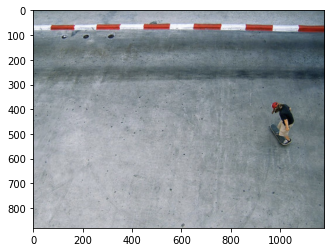

In [13]:
model = vgg1
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq black and white dog is walking through the water endseq


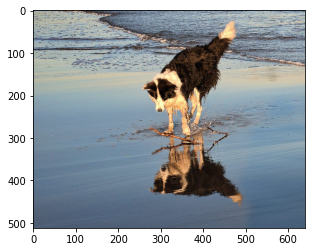

In [14]:
model = vgg1
path = os.path.join(RAND_DIR, "dog.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq boy in black shirt is running down sandy street endseq


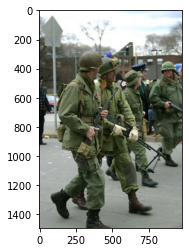

In [15]:
model = vgg1
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq young boy is standing in the sand next to the window endseq


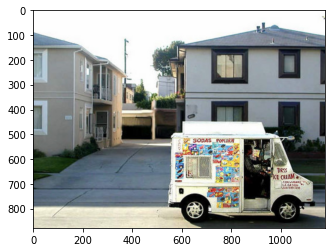

In [16]:
model = vgg1
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the boy is inside the water and holding large rock endseq


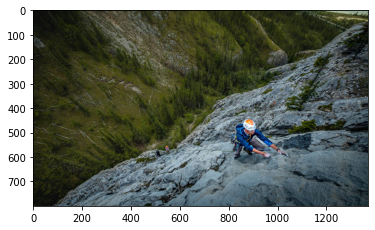

In [17]:
model = vgg1
path = os.path.join(RAND_DIR, "climbing.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq boy in black t shirt is performing dance as he goes down the surface covered with green plastic sword endseq


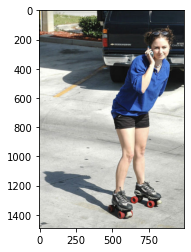

In [18]:
model = vgg1
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq young boy is standing in the sand next to the window endseq


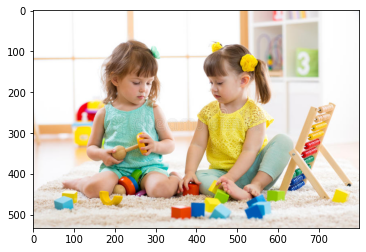

In [19]:
model = vgg1
path = os.path.join(RAND_DIR, "children.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the boy is jumping into the air endseq


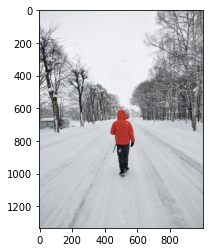

In [20]:
model = vgg1
path = os.path.join(RAND_DIR, "snow.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

### VGG16 Base plus Dropout Model

-----------Predicted-----------
startseq small white dog is jumping over some colored tube endseq


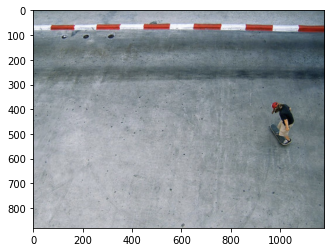

In [21]:
model = vgg2
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq small white dog is jumping over an orange gate endseq


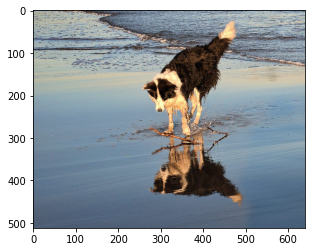

In [22]:
model = vgg2
path = os.path.join(RAND_DIR, "dog.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq little boy is running on the grass endseq


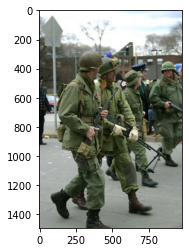

In [23]:
model = vgg2
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq little boy is jumping over some colored steps endseq


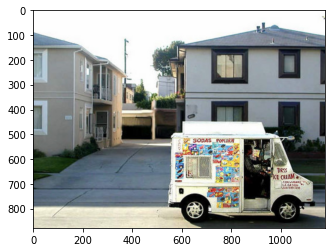

In [24]:
model = vgg2
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq small dog is jumping over some logs endseq


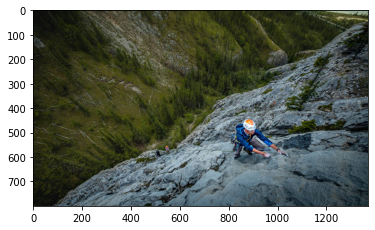

In [25]:
model = vgg2
path = os.path.join(RAND_DIR, "climbing.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq little boy is playing in the sand endseq


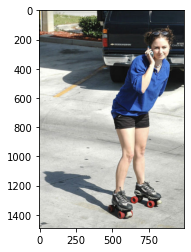

In [26]:
model = vgg2
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq little boy is playing with toy in the front of the blue building endseq


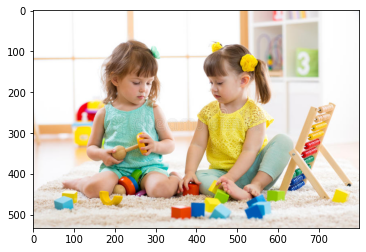

In [27]:
model = vgg2
path = os.path.join(RAND_DIR, "children.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq small dog is running through the sand endseq


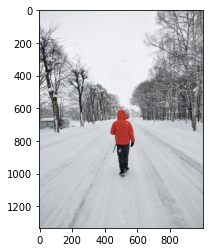

In [28]:
model = vgg2
path = os.path.join(RAND_DIR, "snow.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

### VGG16 Base plus Dropout and Kernel Regulariser Model

-----------Predicted-----------
startseq dog is running through the snow endseq


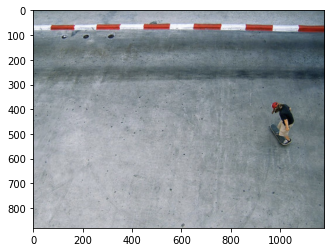

In [29]:
model = vgg3
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq dog is running through the snow endseq


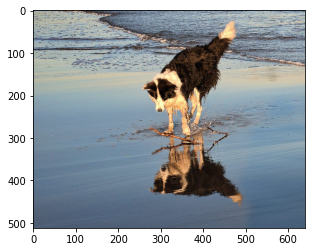

In [30]:
model = vgg3
path = os.path.join(RAND_DIR, "dog.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the dog is running through the snow endseq


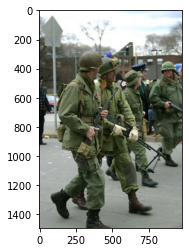

In [31]:
model = vgg3
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq dog is jumping over an obstacle endseq


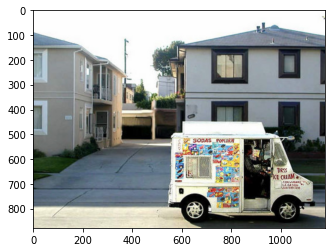

In [32]:
model = vgg3
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq dog is running through the snow endseq


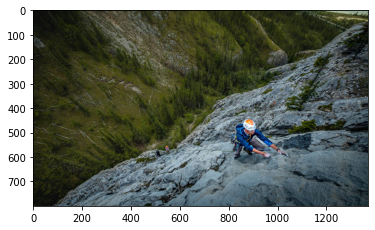

In [33]:
model = vgg3
path = os.path.join(RAND_DIR, "climbing.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the little boy is running through the sand endseq


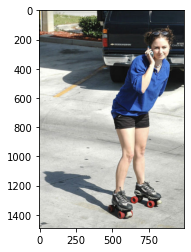

In [34]:
model = vgg3
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the small dog is running through the snow endseq


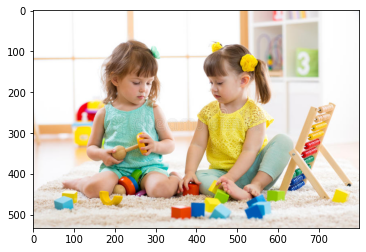

In [35]:
model = vgg3
path = os.path.join(RAND_DIR, "children.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the skier is running through the snow endseq


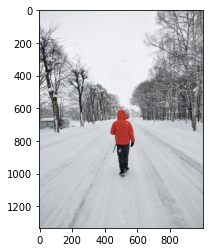

In [79]:
model = vgg3
path = os.path.join(RAND_DIR, "snow.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description2 = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description2)

## Inception v3 Models

### Inception v3 Base Model

96112376/96112376 [==============================] - 1s 0us/step
-----------Predicted-----------
startseq man in purple shirt is doing stunt on bicycle with wheels endseq


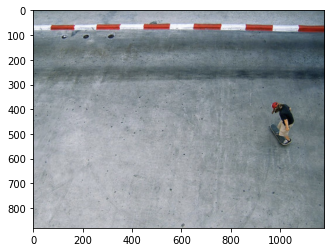

In [37]:
model = inception1
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq dog is running through the water with large chunk of snow behind him endseq


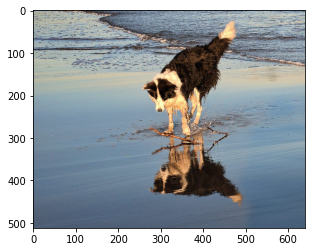

In [65]:
model = inception1
path = os.path.join(RAND_DIR, "dog.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq group of men in camouflage pants and hats playing with their hands in the air endseq


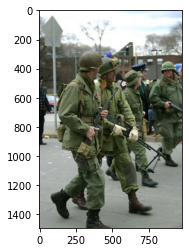

In [39]:
model = inception1
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two people stand outside of truck while one boy sits on its back endseq


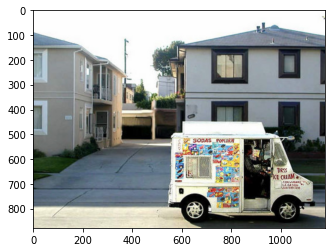

In [40]:
model = inception1
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man is climbing up rock face with snowy mountain behind him endseq


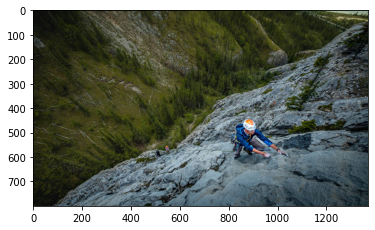

In [41]:
model = inception1
path = os.path.join(RAND_DIR, "climbing.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in business attire is walking down street endseq


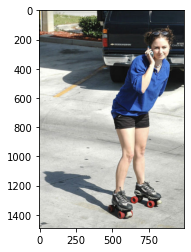

In [42]:
model = inception1
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two children are sitting in costume playing with other children and colorful flag endseq


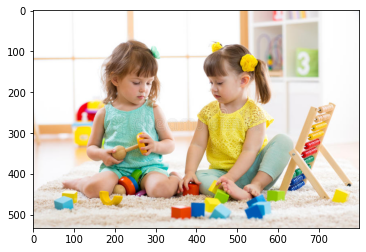

In [43]:
model = inception1
path = os.path.join(RAND_DIR, "children.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two children and one little boy are riding wheelchair in the snow endseq


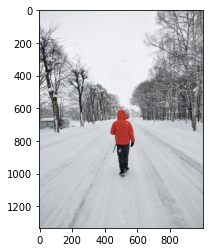

In [44]:
model = inception1
path = os.path.join(RAND_DIR, "snow.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

### Inception v3 Base with Dropout Model

-----------Predicted-----------
startseq skateboarder ollies endseq


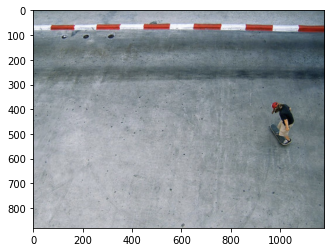

In [45]:
model = inception2
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq black and white dog is running on the beach endseq


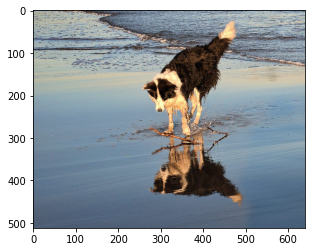

In [81]:
model = inception2
path = os.path.join(RAND_DIR, "dog.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description1 = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description1)

-----------Predicted-----------
startseq man in uniform and two officers wearing hats on head head endseq


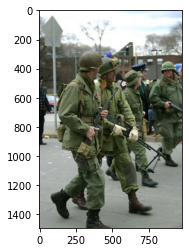

In [75]:
model = inception2
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description3 = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description3)

-----------Predicted-----------
startseq man in blue shirt is walking on the street with shopping cart behind endseq


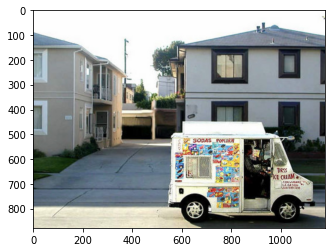

In [48]:
model = inception2
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in red shirt is standing on top of mountain with helmet on his shirt endseq


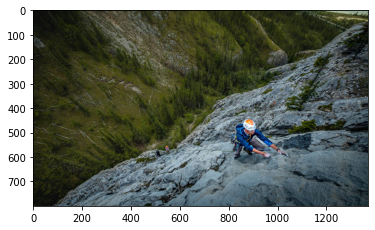

In [49]:
model = inception2
path = os.path.join(RAND_DIR, "climbing.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in black shorts and blue shorts is skateboarding endseq


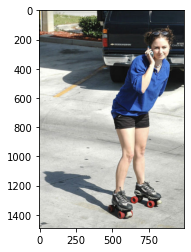

In [50]:
model = inception2
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq little girl in pink shirt is playing with the little girl in the stroller endseq


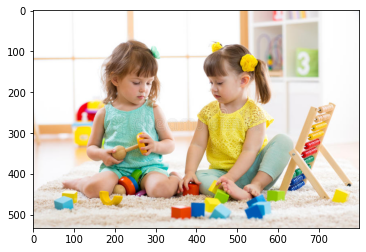

In [51]:
model = inception2
path = os.path.join(RAND_DIR, "children.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two people are walking on the side of the road holding purple car endseq


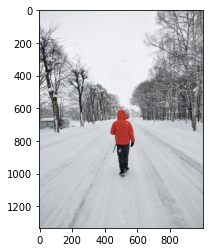

In [52]:
model = inception2
path = os.path.join(RAND_DIR, "snow.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

### Inception v3 Base Model with Dropout and Kernel Regulariser

-----------Predicted-----------
startseq skateboarder in midair endseq


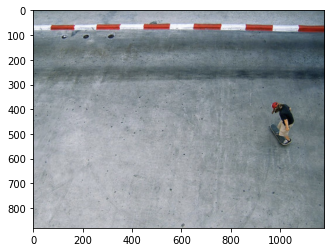

In [53]:
model = inception3
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two dogs are running through the water endseq


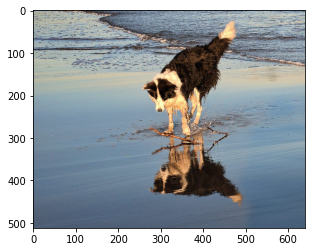

In [54]:
model = inception3
path = os.path.join(RAND_DIR, "dog.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq group of people are standing in front of grafitti angry and white vehicles endseq


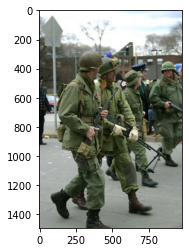

In [74]:
model = inception3
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in blue shirt is standing on the street with his arms crossed endseq


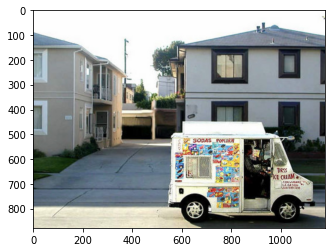

In [56]:
model = inception3
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in red jacket is climbing rock wall endseq


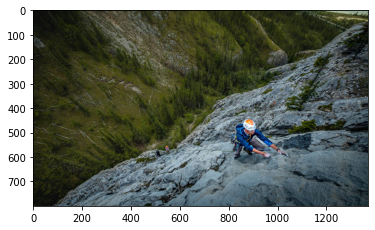

In [57]:
model = inception3
path = os.path.join(RAND_DIR, "climbing.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in blue shirt and black pants is standing on the sidewalk endseq


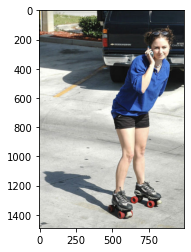

In [58]:
model = inception3
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq little girl in pink shirt is running on the grass endseq


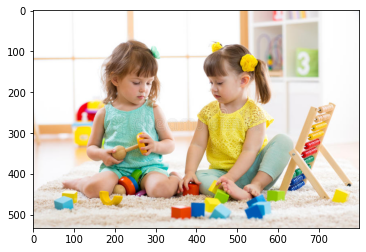

In [59]:
model = inception3
path = os.path.join(RAND_DIR, "children.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in red jacket is riding on the side of mountain endseq


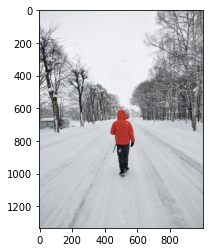

In [77]:
model = inception3
path = os.path.join(RAND_DIR, "snow.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

## Text to Audio

Audio output is introduced using Google's Text-to-Speech (gTTS) API.

In [61]:
#using the last predicted image description to convert to audio output
s = description
s2 = ' '.join(s.split(' ')[1:-1])
print(s2)

man in red jacket is riding on the side of mountain


In [62]:
pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
#Import Google Text to Speech
from gtts import gTTS
#Import Audio method from IPython's Display Class
from IPython.display import Audio

In [82]:
#using the last predicted image description to convert to audio output
a = description1
a2 = ' '.join(a.split(' ')[1:-1])
print(a2)

#Provide the string to convert to speech
tts = gTTS(a2)
#save the string converted to speech as a .wav file
tts.save('dog.wav')
sound_file = 'dog.wav'
Audio(sound_file, autoplay=True) 

black and white dog is running on the beach


In [80]:
#using the last predicted image description to convert to audio output
b = description2
b2 = ' '.join(b.split(' ')[1:-1])
print(b2)

#Provide the string to convert to speech
tts = gTTS(b2)
#save the string converted to speech as a .wav file
tts.save('snow.wav')
sound_file = 'snow.wav'
Audio(sound_file, autoplay=True) 


the skier is running through the snow


In [76]:
#using the last predicted image description to convert to audio output
c = description3
c2 = ' '.join(c.split(' ')[1:-1])
print(c2)

#Provide the string to convert to speech
tts = gTTS(c2)
#save the string converted to speech as a .wav file
tts.save('soldier.wav')
sound_file = 'soldier.wav'
Audio(sound_file, autoplay=True) 

man in uniform and two officers wearing hats on head head


## Summary

## Improvements